In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np

from pathlib import Path
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt


In [3]:
GCS_PATH = Path('')

In [4]:
MONET_FILENAMES = list(GCS_PATH.glob('monet_pt/*.pt'))
print('Monet ptord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = list(GCS_PATH.glob('photo_pt/*.pt'))
print('Photo ptord Files:', len(PHOTO_FILENAMES))

Monet ptord Files: 5
Photo ptord Files: 20


In [5]:
print(MONET_FILENAMES)

[PosixPath('monet_pt/monet_dataset_00.pt'), PosixPath('monet_pt/monet_dataset_03.pt'), PosixPath('monet_pt/monet_dataset_02.pt'), PosixPath('monet_pt/monet_dataset_01.pt'), PosixPath('monet_pt/monet_dataset_04.pt')]


In [6]:
# Load the PyTorch tensors from the .pt files
monet_data = []
for file in os.listdir('monet_pt'):
    file_path = os.path.join('monet_pt', file)
    tensor = torch.load(file_path)
    monet_data.append(tensor)

photo_data = []
for file in os.listdir('photo_pt'):
    file_path = os.path.join('photo_pt', file)
    tensor = torch.load(file_path)
    photo_data.append(tensor)

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        img = self.data[index]
        if isinstance(img, torch.utils.data.dataset.TensorDataset):
            # If it's a TensorDataset, get the first tensor
            img = img.tensors[0]
        
        # Ensure the tensor is in the correct format (C, H, W)
        if img.dim() == 2:  # If it's a 2D tensor, add a channel dimension
            img = img.unsqueeze(0)
        elif img.dim() == 3 and img.shape[0] != 3:  # If it's (H, W, C), transpose to (C, H, W)
            img = img.permute(2, 0, 1)
        return img

monet_dataset = CustomDataset(monet_data)
photo_dataset = CustomDataset(photo_data)

def custom_collate(batch):
    # Each item in batch is already a tensor, so we just return the list
    return batch

data_loader_monet = torch.utils.data.DataLoader(
    monet_dataset, 
    batch_size=32, 
    shuffle=True, 
    collate_fn=custom_collate
)

data_loader_photo = torch.utils.data.DataLoader(
    photo_dataset, 
    batch_size=32, 
    shuffle=True, 
    collate_fn=custom_collate
)

Batch type: <class 'list'>
Number of images in batch: 5
Shape of first image: torch.Size([3, 256, 256])


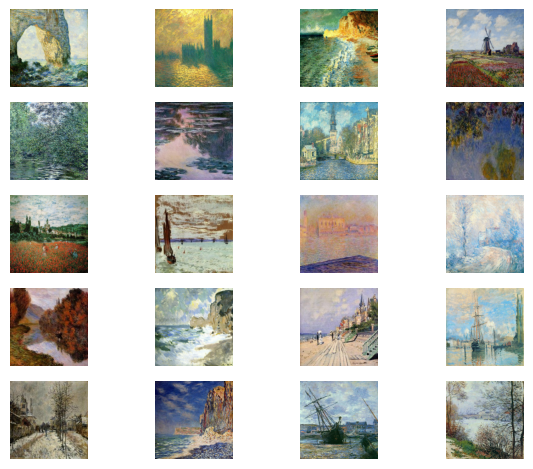

Batch type: <class 'list'>
Number of images in batch: 20
Shape of first image: torch.Size([3, 256, 256])


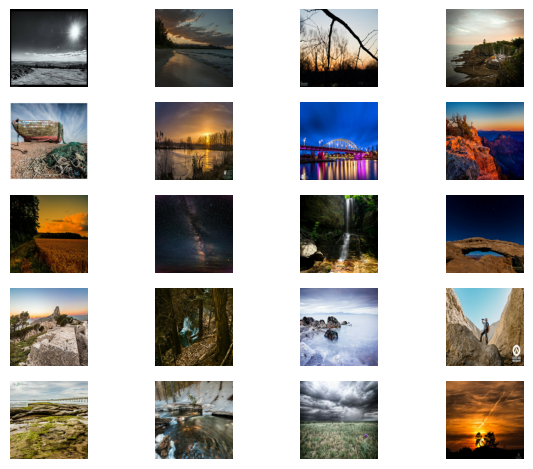

In [10]:

def plot_images(data_loader, num_images=5):
    # Get a batch of images
    batch = next(iter(data_loader))
    
    print(f"Batch type: {type(batch)}")
    print(f"Number of images in batch: {len(batch)}")
    print(f"Shape of first image: {batch[0][0].shape}")
    
    # Ensure we don't try to plot more images than we have
    #num_images = len(batch)
    # Plot images
    fig, axes = plt.subplots(num_images, 4)
    if num_images == 1:
        axes = [axes]  # Make axes indexable if there's only one image
    for i in range(num_images):
        for j in range(4):
            # Convert to numpy and ensure it's in the range [0, 1]
            img = batch[i][j].cpu().numpy()

            
            # Your images are in (C, H, W) format, so we need to transpose them for plotting
            img = img.transpose(1, 2, 0)
            axes[i][j].imshow(img)
            axes[i][j].axis('off')
            #break
    plt.tight_layout()
    plt.show()
    
    return img

# Use the function
example_monet = plot_images(data_loader_monet)
example_photo = plot_images(data_loader_photo)

In [8]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    result = nn.Sequential(
        nn.Conv2d(OUTPUT_CHANNELS, filters, kernel_size=size, stride=2, padding=size//2, bias=False),
        nn.InstanceNorm2d(filters) if apply_instancenorm else nn.Identity(),
        nn.LeakyReLU(0.2)
    )
    return result

In [9]:

def upsample(filters, size, apply_dropout=False):
    result = nn.Sequential(
        nn.ConvTranspose2d(filters, filters, kernel_size=size, stride=2, padding=size//2, bias=False),
        nn.InstanceNorm2d(filters),
        nn.Dropout2d(0.5) if apply_dropout else nn.Identity(),
        nn.ReLU()
    )
    return result

In [11]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.down_stack = nn.ModuleList([
            downsample(64, 4, apply_instancenorm=False),
            downsample(128, 4),
            downsample(256, 4),
            downsample(512, 4),
            downsample(512, 4),
            downsample(512, 4),
            downsample(512, 4),
            downsample(512, 4),
        ])

        self.up_stack = nn.ModuleList([
            upsample(512, 4, apply_dropout=True),
            upsample(512, 4, apply_dropout=True),
            upsample(512, 4, apply_dropout=True),
            upsample(512, 4),
            upsample(256, 4),
            upsample(128, 4),
            upsample(64, 4),
        ])

        self.last = nn.ConvTranspose2d(512, OUTPUT_CHANNELS, kernel_size=4, stride=2, padding=1, bias=False)

    def forward(self, x):
        skips = []

        for down in self.down_stack:
            x = down(x)
            skips.append(x)

        skips = list(reversed(skips[:-1]))

        for up, skip in zip(self.up_stack, skips):
            x = up(x)
            x = torch.cat([x, skip], dim=1)

        x = self.last(x)

        return x

generator = Generator()

In [12]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.down1 = downsample(64, 4, apply_instancenorm=False)
        self.down2 = downsample(128, 4)
        self.down3 = downsample(256, 4)

        self.conv = nn.Conv2d(256, 512, kernel_size=4, stride=1, bias=False)
        self.norm1 = nn.InstanceNorm2d(512)
        self.leaky_relu = nn.LeakyReLU()

        self.last = nn.Conv2d(512, 1, kernel_size=4, stride=1)

    def forward(self, x):
        x = self.down1(x)
        x = self.down2(x)
        x = self.down3(x)

        x = nn.functional.pad(x, (1, 1, 1, 1))  # equivalent to ZeroPadding2D
        x = self.conv(x)
        x = self.norm1(x)
        x = self.leaky_relu(x)

        x = nn.functional.pad(x, (1, 1, 1, 1))  # equivalent to ZeroPadding2D
        x = self.last(x)

        return x

In [13]:
monet_generator = Generator() # transforms photos to Monet-esque paintings
photo_generator = Generator() # transforms Monet paintings to be more like photos

monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
photo_discriminator = Discriminator() # differentiates real photos and generated photos

In [ ]:
to_monet = monet_generator(example_photo)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()